# Forecasting with sktime

[Github weblink](https://github.com/alan-turing-institute/sktime/blob/master/examples/forecasting.ipynb)

In this tutorial, we implement and evaluate some of the available forecasting strategies in `sktime`, using both the low-level and high-level interface, with both univariate and multivariate time series data. 

## Preliminaries

In [1]:
from sktime.forecasters import DummyForecaster
from sktime.forecasters import ARIMAForecaster
from sktime.forecasters import ExpSmoothingForecaster
from sktime.forecasters import EnsembleForecaster
from sktime.highlevel.tasks import ForecastingTask
from sktime.highlevel.strategies import ForecastingStrategy
from sktime.highlevel.strategies import Forecasting2TSRReductionStrategy
from sktime.datasets import load_shampoo_sales
from sktime.datasets import load_longley
from sktime.transformers.compose import Tabulariser
from sktime.pipeline import Pipeline

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from warnings import filterwarnings

In [2]:
filterwarnings(action='ignore', category=FutureWarning, module='statsmodels')
%matplotlib inline

## Low-level interface

### Single series forecasting

* Split the data into train, test and optionally also an updated dataset
* Put the data into the expected input format, i.e. a nested pandas Series

Load shampoo sales dataset from `sktime` containing monthly sale counts of shampoo over three years. 

In [3]:
shampoo = load_shampoo_sales()
s = shampoo.iloc[0]
s.head()

0    266.0
1    145.9
2    183.1
3    119.3
4    180.3
Name: Sales, dtype: float64

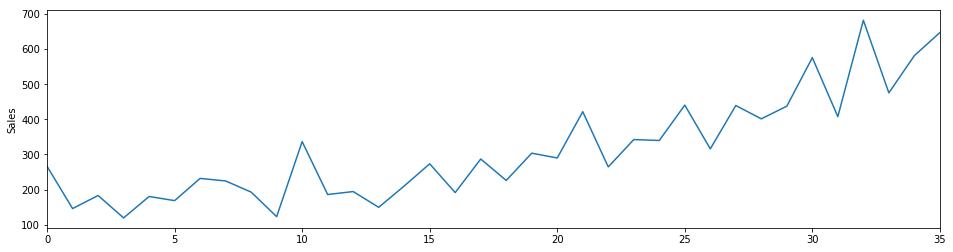

In [4]:
fig, ax = plt.subplots(1, figsize=plt.figaspect(.25))
s.plot(ax=ax)
ax.set(ylabel=s.name);

In [5]:
# split data into train, update and test
train = pd.Series([shampoo.iloc[0].iloc[:30]])
test = pd.Series([shampoo.iloc[0].iloc[30:]])

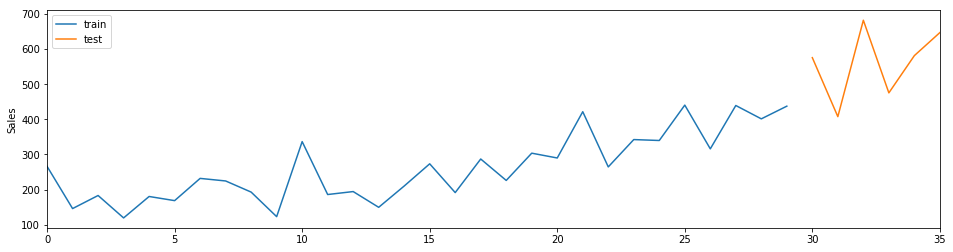

In [6]:
fig, ax = plt.subplots(1, figsize=plt.figaspect(.25))
train.iloc[0].plot(ax=ax, label='train')
test.iloc[0].plot(ax=ax, label='test')
ax.set(ylabel=s.name)
plt.legend();

In [7]:
# arima model
order = (3, 2, 1)
m = ARIMAForecaster(order=order)
m.fit(train)

fh = np.arange(1, 7)
y_pred = m.predict(fh=fh)
y_pred

30    398.089691
31    466.013453
32    441.347911
33    476.524325
34    457.849554
35    500.079676
dtype: float64

In [8]:
# evaluate forecasts using default scorer (root mean squared error)
m.score(test, fh=fh)

146.96807856765895

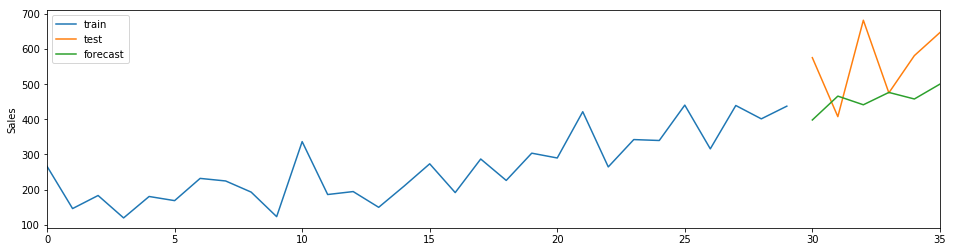

In [9]:
fig, ax = plt.subplots(1, figsize=plt.figaspect(.25))
train.iloc[0].plot(ax=ax, label='train')
test.iloc[0].plot(ax=ax, label='test')
y_pred.plot(ax=ax, label='forecast')
ax.set(ylabel=s.name)
plt.legend();

### Comparing forecasts with other models

In [10]:
# simple exponential smoothing
m = ExpSmoothingForecaster()
m.fit(train)
m.score(test, fh=fh)

182.55208208806164

In [11]:
# ensemble of forecasters
estimators = [
    ('ses', ExpSmoothingForecaster()), 
    ('holt', ExpSmoothingForecaster(trend='additive')), 
    ('damped', ExpSmoothingForecaster(trend='additive', damped=True))
]
m = EnsembleForecaster(estimators=estimators)
m.fit(train)
m.score(test, fh=fh)

155.1063712366893

#### Common hyper-parameter interface

In [12]:
# check set params interface
# simple exponential smoothing
m = ExpSmoothingForecaster()
m.fit(train)
m.get_params()

{'check_input': True,
 'damped': False,
 'damping_slope': None,
 'optimized': True,
 'remove_bias': False,
 'seasonal': None,
 'seasonal_periods': None,
 'smoothing_level': None,
 'smoothing_seasonal': None,
 'smoothing_slope': None,
 'trend': None,
 'use_basinhopping': False,
 'use_boxcox': False}

In [13]:
# automatically fitted param
m._fitted_estimator.params['smoothing_level']

0.35282128167902543

In [14]:
m.set_params(**{'smoothing_level': .75})
m.fit(train)
m.score(test, fh=fh)

162.49044852118521

In [15]:
# user given fixed parameter
m._fitted_estimator.params['smoothing_level']

0.75

### Forecasting with exogenous time series

In [16]:
# load multivariate data
X, y = load_longley(return_X_y=True)

# get data in required format
y_train = pd.Series([y.iloc[0].iloc[:13]])
y_test = pd.Series([y.iloc[0].iloc[13:]])

X_train = pd.DataFrame([pd.Series([X.iloc[0, i].iloc[:13]]) for i in range(X.shape[1])]).T
X_train.columns = X.columns
X_test = pd.DataFrame([pd.Series([X.iloc[0, i].iloc[13:]]) for i in range(X.shape[1])]).T
X_test.columns = X.columns

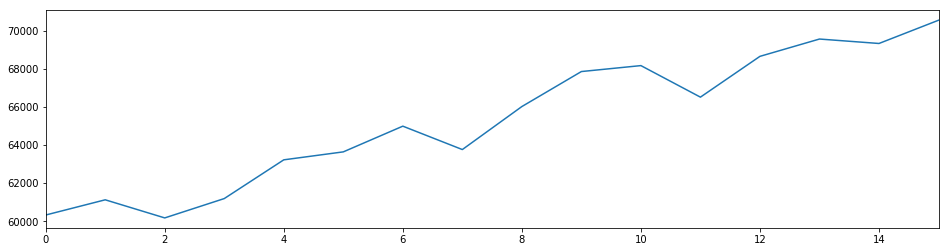

In [17]:
fig, ax = plt.subplots(1, figsize=plt.figaspect(.25))
s = y.iloc[0]
s.plot(ax=ax);

In [18]:
y_train.iloc[0].tail()

8     66019
9     67857
10    68169
11    66513
12    68655
Name: TOTEMP, dtype: int64

In [19]:
y_test.iloc[0]

13    69564
14    69331
15    70551
Name: TOTEMP, dtype: int64

In [20]:
# forecasting horizon for test period
fh = np.arange(y_test.iloc[0].shape[0]) + 1
fh

array([1, 2, 3])

Compare model performance with and without exogenous features

In [21]:
order = (3, 2, 1)

In [22]:
m = ARIMAForecaster(order=order)
m.fit(y_train, X=X_train)
m.predict(fh=fh, X=X_test)

13    69459.894738
14    68996.247410
15    71092.492103
dtype: float64

In [23]:
m.score(y_test, X=X_test, fh=fh)

372.42936662335666

In [24]:
m = ARIMAForecaster(order=order)
m.fit(y_train)
m.score(y_test,fh=fh)

1400.8569388795754

## High-level interface

* Put data into expected format, i.e. nested pandas DataFrame
* Specify forecasting task 
* Use forecasting strategies

### Single series forecasting

In [25]:
# get data into expected nested format
shampoo = load_shampoo_sales(return_y_as_dataframe=True)
train = pd.DataFrame(pd.Series([shampoo.iloc[0, 0].iloc[:24]]), columns=shampoo.columns)
update = pd.DataFrame(pd.Series([shampoo.iloc[0, 0].iloc[:30]]), columns=shampoo.columns)
test = pd.DataFrame(pd.Series([shampoo.iloc[0, 0].iloc[30:]]), columns=shampoo.columns)

In [26]:
# create forecasting task specifying variable to be forecasted and forecasting horizon
task = ForecastingTask(target='ShampooSales', fh=[6, 7, 8], metadata=train)

In [27]:
# ARIMA forecasting strategy
estimator = ARIMAForecaster()
m = ForecastingStrategy(estimator=estimator)
m.fit(task, train)
m.predict()

29    242.356876
30    228.803899
31    216.008826
dtype: float64

In [28]:
# update estimator with data up to point of prediction and predict again
m.update(update)
m.predict()

0    323.158046
1    251.124862
2    137.741043
dtype: float64

In [29]:
# naive forecasting strategies
estimator = DummyForecaster(strategy='mean')
m = ForecastingStrategy(estimator=estimator)
m.fit(task, train)
m.predict()

29    229.625
30    229.625
31    229.625
dtype: float64

#### Reduction strategies

Reduction strategies allow us to solve forecasting tasks with time-series regression algorithms using a rolling window approach.

In [30]:
# define simple time-series regressor using time-series as features
steps = [
    ('tabularise', Tabulariser()),
    ('clf', RandomForestRegressor(n_estimators=100))
]
estimator = Pipeline(steps)

task = ForecastingTask(target='ShampooSales', fh=[1, 2],
                       metadata=train)

s = Forecasting2TSRReductionStrategy(estimator=estimator)
s.fit(task, train)
y_pred = s.predict()
y_pred

24    337.219
25    336.320
Name: Sales, dtype: float64

In [31]:
test = update.iloc[0, 0][y_pred.index]
np.sqrt(mean_squared_error(test, y_pred)) 

73.61658020106643

In [32]:
# number of windows (number of rows)
s.rw.get_n_splits()

19

In [33]:
# window length (number of features)
s.window_length_

4

### Forecasting with exogenous time series

In [34]:
# get data into expected nested format
longley = load_longley(return_X_y=False)
train = pd.DataFrame([pd.Series([longley.iloc[0, i].iloc[:13]]) for i in range(longley.shape[1])]).T
train.columns = longley.columns

test = pd.DataFrame([pd.Series([longley.iloc[0, i].iloc[13:]]) for i in range(longley.shape[1])]).T
test.columns = longley.columns

In [35]:
train

,GNPDEFL,GNP,UNEMP,ARMED,POP,TOTEMP
0,0 83.0 1 88.5 2 88.2 3 89....,0 234289 1 259426 2 258054 3 2...,0 2356 1 2325 2 3682 3 3351 4 ...,0 1590 1 1456 2 1616 3 1650 4 ...,0 107608 1 108632 2 109773 3 1...,0 60323 1 61122 2 60171 3 6118...


In [36]:
# create forecasting task specifying variable to be forecasted and forecasting horizon
task = ForecastingTask(target='TOTEMP', fh=[1, 2, 3], metadata=train)

In [37]:
# ARIMA forecasting strategy
estimator = ARIMAForecaster(order=order)
m = ForecastingStrategy(estimator=estimator)
m.fit(task, train)
m.predict(data=test)

13    69459.894738
14    68996.247410
15    71092.492103
dtype: float64